From here: https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c

## Imports

In [13]:
#TODO: clean imports
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import numpy as np
import matplotlib.pyplot as plt

## Preprocessing

In [14]:

train_data, val_test_data = tf.keras.utils.image_dataset_from_directory(
    "data/",
    labels="inferred", # so men and women classes are used in nested folders
    label_mode="binary", # encode men and women as 0 and 1
    class_names= ("men", "women"),
    validation_split=0.2,
    image_size=(256, 256), # resize for cnn
    interpolation="bilinear", # use standard interpolation
    shuffle=True, # shuffle so men and women are not in order
    batch_size=32,  
    # batch_size=None, # probably batch later? 
    subset="both",
    seed=14, # Karen's favourite number
    )
 

Found 3330 files belonging to 2 classes.
Using 2664 files for training.
Using 666 files for validation.


In [15]:
val_data = val_test_data.take(333) # get 10 % of original data
test_data = val_test_data.skip(333)

#NOTE: can be tested like this: 
# len(list(val_data)), len(list(test_data))

In [16]:
def plot_imgs(images_arr):
    for img in images_arr:
        # plt.rcParams["figure.figsize"] 
        # plt.imshow(np.array(img[0][0].numpy(), dtype=int))
        # plt.axis('off')
            
        # plt.tight_layout()
        # plt.show()
        # plt.close()
        fig, ax = plt.subplots(figsize=(2, 2))

        ax.imshow(np.array(img[0][0].numpy(), dtype=int))
        ax.axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()

# plot_imgs(val_data.take(5))

## Potentially generate more images 
Might not be smart: 
- In https://arxiv.org/pdf/2303.14608.pdf the authors found some negative effects of data augmentation on interpretability, although the research is not definitive. 
- Addign data augmentation might complicate the project, which is not (yet) desirable.  

In [5]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [6]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.3
) # Generator for our training data

In [7]:
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [8]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=TRAIN_PATH,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
                                                     
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=VAL_PATH,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

NameError: name 'TRAIN_PATH' is not defined

## Create model

Some notes:
- We do not use padding, because by looking at the training data we see that the border hardly ever containts relevant information.
- 

In [17]:

model = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    Conv2D(32, kernel_size=(7, 7), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(64, kernel_size=(9, 9), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='relu'),
])

In [26]:
model_tf = Sequential()

model_tf.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_tf.add(MaxPooling2D((2, 2)))
model_tf.add(Conv2D(64, (3, 3), activation='relu'))
model_tf.add(MaxPooling2D((2, 2)))
model_tf.add(Conv2D(64, (3, 3), activation='relu'))
model_tf.add(MaxPooling2D((2, 2)))


model_tf.add(Flatten())
model_tf.add(Dense(64, activation='relu'))
model_tf.add(Dense(1, activation='sigmoid'))


In [27]:
# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # from logits bc no softmax at the end
#             #   metrics=['val_acc', 'val_loss'])
#               metrics=['accuracy'])

model_tf.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_tf.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 30, 30, 64)      

## Fit models

In [34]:
def create_model_small():
    model_small = Sequential()

    model_small.add(Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model_small.add(MaxPooling2D((2, 2)))
    model_small.add(Flatten())
    model_small.add(Dense(1, activation="sigmoid"))

    return model_small

# model_small.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     metrics=['accuracy']
# )

In [35]:
history_small = {}
lrs = [0.5, 0.1, 0.05, 0.01, 0.005, 0.0001, 0.00001, 0.000001]

for i, lr in enumerate(lrs):
    print(f"Iteration: {i} Learning Rate: {lr}")

    model_small = create_model_small()
    
    model_small.compile(optimizer=Adam(learning_rate=lr),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                metrics=['accuracy'])

    history_small[i] = model_small.fit(
        train_data,
        batch_size=32,
        epochs=5,
        validation_data=val_data,
        use_multiprocessing=True,
    )

# history_small = model_small.fit(
#     train_data,
#     epochs=5,
#     validation_data=val_data,
#     use_multiprocessing=True,
# )

Iteration: 0 Learning Rate: 0.5
Epoch 1/5
84/84 [==============================] - 37s 419ms/step - loss: 101070.8828 - accuracy: 0.5709 - val_loss: 0.6907 - val_accuracy: 0.5631
Epoch 2/5
84/84 [==============================] - 37s 426ms/step - loss: 0.6878 - accuracy: 0.5574 - val_loss: 0.6857 - val_accuracy: 0.5631
Epoch 3/5
84/84 [==============================] - 37s 420ms/step - loss: 0.6884 - accuracy: 0.5612 - val_loss: 0.6853 - val_accuracy: 0.5631
Epoch 4/5
84/84 [==============================] - 38s 433ms/step - loss: 0.6917 - accuracy: 0.5417 - val_loss: 0.6935 - val_accuracy: 0.4369
Epoch 5/5
84/84 [==============================] - 37s 423ms/step - loss: 0.6903 - accuracy: 0.5379 - val_loss: 0.6852 - val_accuracy: 0.5631
Iteration: 1 Learning Rate: 0.1
Epoch 1/5
84/84 [==============================] - 37s 415ms/step - loss: 3411.4126 - accuracy: 0.5747 - val_loss: 0.6857 - val_accuracy: 0.5631
Epoch 2/5
84/84 [==============================] - 36s 413ms/step - loss: 0.

In [36]:
model_small = create_model_small()

model_small.compile(optimizer=Adam(learning_rate=1e-06),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
            metrics=['accuracy'])

history_small[i] = model_small.fit(
    train_data,
    batch_size=64,
    epochs=15,
    validation_data=val_data,
    use_multiprocessing=True,
)

Epoch 1/15
84/84 [==============================] - 33s 375ms/step - loss: 11.9081 - accuracy: 0.5199 - val_loss: 10.6639 - val_accuracy: 0.5135
Epoch 2/15
84/84 [==============================] - 34s 393ms/step - loss: 9.5257 - accuracy: 0.5375 - val_loss: 9.9287 - val_accuracy: 0.5180
Epoch 3/15
84/84 [==============================] - 42s 487ms/step - loss: 8.9236 - accuracy: 0.5413 - val_loss: 9.3870 - val_accuracy: 0.5240
Epoch 4/15
84/84 [==============================] - 41s 467ms/step - loss: 8.4911 - accuracy: 0.5548 - val_loss: 9.0068 - val_accuracy: 0.5345
Epoch 5/15
84/84 [==============================] - 44s 510ms/step - loss: 8.1617 - accuracy: 0.5544 - val_loss: 8.8035 - val_accuracy: 0.5420
Epoch 6/15
84/84 [==============================] - 43s 496ms/step - loss: 7.8637 - accuracy: 0.5604 - val_loss: 8.3193 - val_accuracy: 0.5375
Epoch 7/15
84/84 [==============================] - 41s 475ms/step - loss: 7.5207 - accuracy: 0.5571 - val_loss: 8.3013 - val_accuracy: 0.54

In [28]:
history = model_tf.fit(
    train_data,
    epochs=5,
    validation_data=val_data,
    use_multiprocessing=True,

)

Epoch 1/5
84/84 [==============================] - 151s 2s/step - loss: 44.6810 - accuracy: 0.5724 - val_loss: 0.6707 - val_accuracy: 0.6066
Epoch 2/5
84/84 [==============================] - 167s 2s/step - loss: 0.6085 - accuracy: 0.6824 - val_loss: 0.7500 - val_accuracy: 0.5751
Epoch 3/5
84/84 [==============================] - 171s 2s/step - loss: 0.4744 - accuracy: 0.7650 - val_loss: 0.8307 - val_accuracy: 0.5841
Epoch 4/5
84/84 [==============================] - 154s 2s/step - loss: 0.3581 - accuracy: 0.8378 - val_loss: 1.0165 - val_accuracy: 0.5811
Epoch 5/5
84/84 [==============================] - 164s 2s/step - loss: 0.2967 - accuracy: 0.8758 - val_loss: 1.3978 - val_accuracy: 0.5871


In [19]:
history = {}
lrs = [0.5, 0.1, 0.05, 0.01, 0.005, 0.0001, 0.00001, 0.000001]

for i, lr in enumerate(lrs):
    print(f"Iteration: {i}")
    model_tf.compile(optimizer=Adam(learning_rate=lr),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # from logits bc no softmax at the end
                #   metrics=['val_acc', 'val_loss'])
                metrics=['accuracy'])

    history[i] = model_tf.fit(
        train_data,
        batch_size=32,
        epochs=5,
        validation_data=val_data,
        use_multiprocessing=True,
    )

Iteration: 0
Epoch 1/5
84/84 [==============================] - 178s 2s/step - loss: 29297.2969 - accuracy: 0.4797 - val_loss: 0.6959 - val_accuracy: 0.5631
Epoch 2/5
84/84 [==============================] - 194s 2s/step - loss: 0.6881 - accuracy: 0.4711 - val_loss: 0.6863 - val_accuracy: 0.4369
Epoch 3/5
84/84 [==============================] - 201s 2s/step - loss: 0.6897 - accuracy: 0.4508 - val_loss: 0.7027 - val_accuracy: 0.5631
Epoch 4/5
84/84 [==============================] - 175s 2s/step - loss: 0.6890 - accuracy: 0.4681 - val_loss: 0.6869 - val_accuracy: 0.4369
Epoch 5/5
84/84 [==============================] - 160s 2s/step - loss: 0.6944 - accuracy: 0.4583 - val_loss: 0.6898 - val_accuracy: 0.4369
Iteration: 1
Epoch 1/5
84/84 [==============================] - 149s 2s/step - loss: 0.6842 - accuracy: 0.4666 - val_loss: 0.6923 - val_accuracy: 0.4369
Epoch 2/5
84/84 [==============================] - 158s 2s/step - loss: 0.6842 - accuracy: 0.4471 - val_loss: 0.6874 - val_accurac

KeyboardInterrupt: 

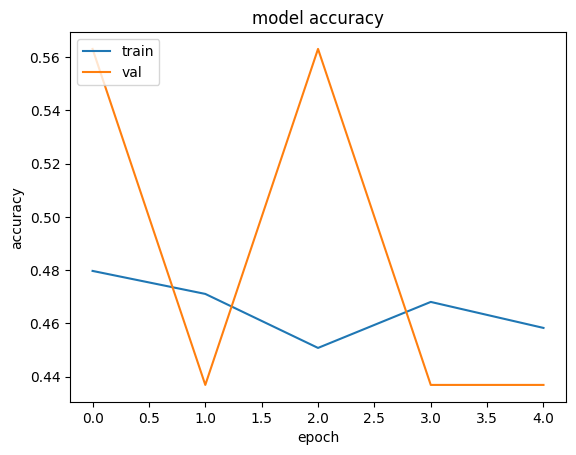

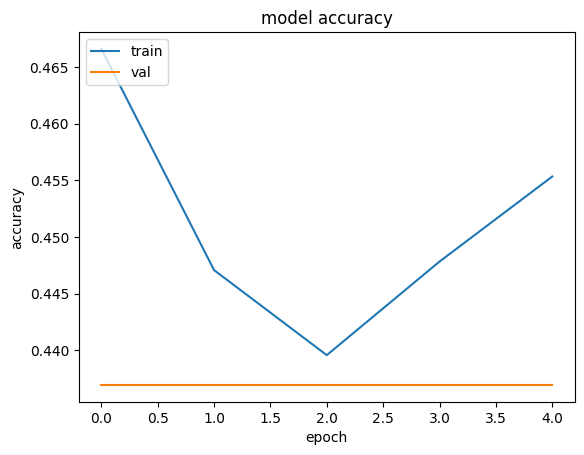

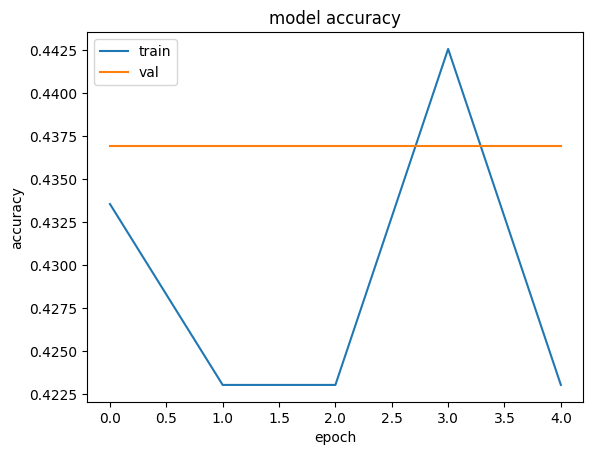

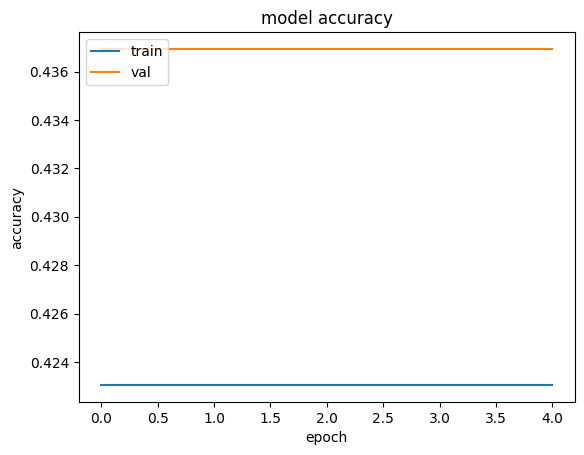

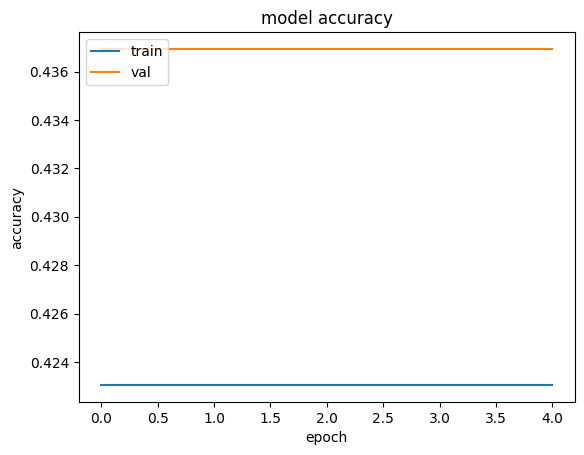

In [22]:
for value in history.values():
        
    fig, ax = plt.subplots()

    ax.plot(value.history['accuracy'])
    ax.plot(value.history['val_accuracy'])
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'val'], loc='upper left')

    plt.show()

## Random stuff that we might still use

In [39]:
def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
for layer in model.layers:
    if 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        axis_x=1
        #plotting all the filters
        for i in range(filters.shape[3]):
        #for i in range(6):
            #get the filters
            filt=filters[:,:,:, i]
            plotFilters(filt)

In [ ]:
#Visualizing the filters
#plt.figure(figsize=(5,5))
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, weights.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(weights.shape[3])
        filter_cnt=1
        #plotting all the filters
        for i in range(filters.shape[3]):
        #for i in range(6):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting ecah channel
            for j in range(filters.shape[0]):
                #plt.figure( figsize=(5, 5) )
                #f = plt.figure(figsize=(10,10))
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()
        

In [47]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

(1, 75, 75, 16)
(1, 75, 75, 16)
(1, 75, 75, 32)
(1, 37, 37, 32)
(1, 37, 37, 64)
(1, 18, 18, 64)
(1, 18, 18, 64)
(1, 20736)
(1, 512)
(1, 1)


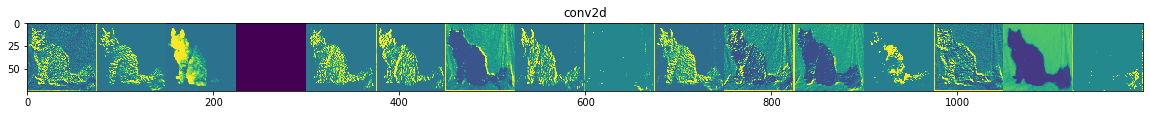

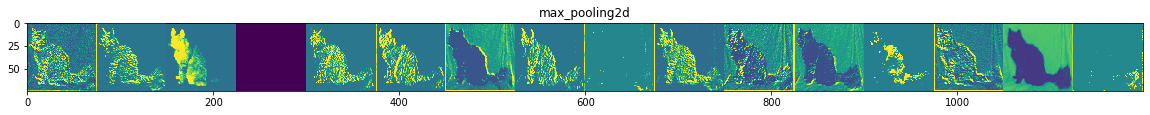

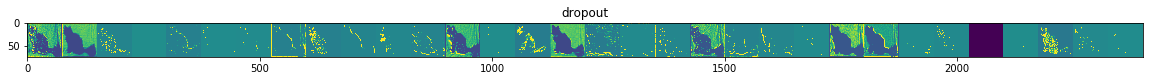

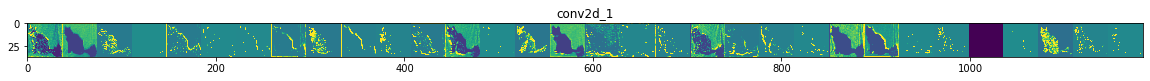

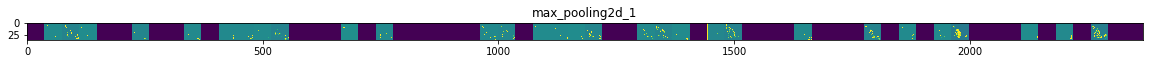

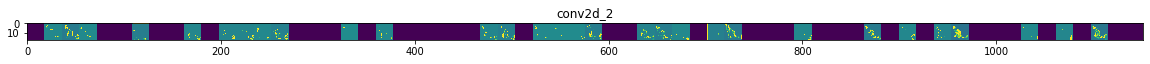

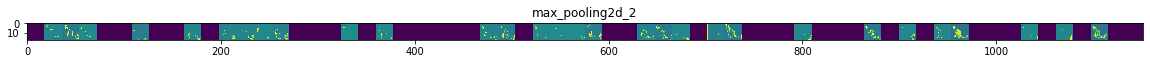

In [48]:

img_path='C:\\Data\\CV\\dogs-vs-cats\\test1\\136.jpg' #dog
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

#img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

(1, 75, 75, 16)
(1, 75, 75, 16)
(1, 75, 75, 32)
(1, 37, 37, 32)
(1, 37, 37, 64)
(1, 18, 18, 64)
(1, 18, 18, 64)
(1, 20736)
(1, 512)
(1, 1)


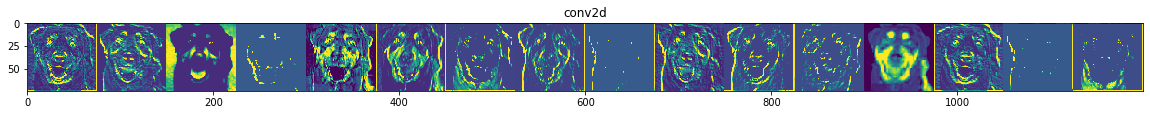

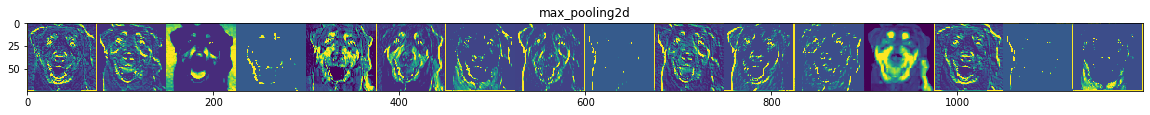

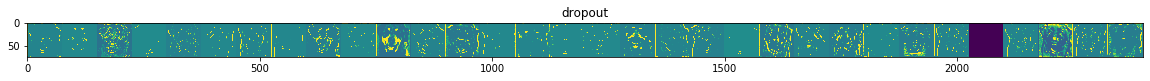

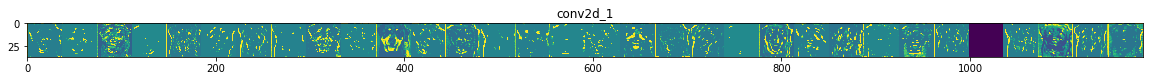

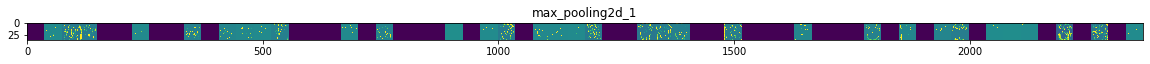

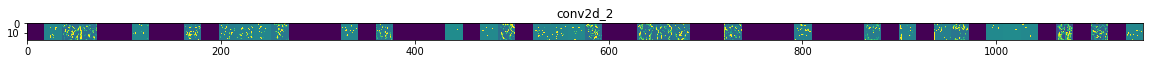

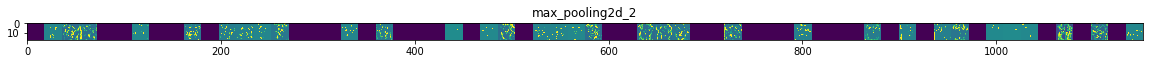

In [49]:
img_path='c:\\data\\cv\\dogs-vs-cats\\test1\\137.jpg' #dog
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(150, 150))  
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)                   
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x 

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

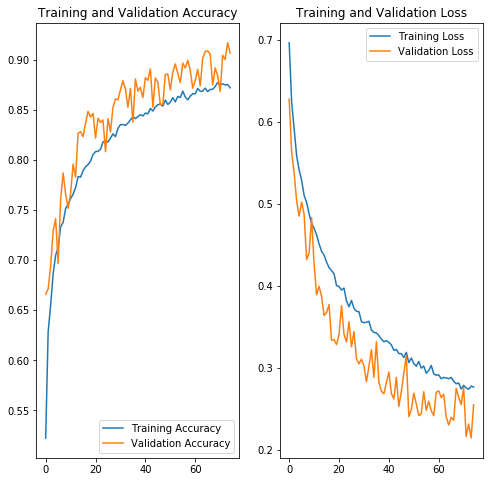

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()